# Model: Support Vector Machine (SVM) with RBF Kernel


## Description
- Radial Basis Function Support Vector Machine is an ML algorithm that can be used for classification and regression tasks. It can work well with non-linear data.
- It works by mapping the input data into a high-dimensional feature space and the Radial Basis kernel function measures the similarity between pairs of data points within the space.
    - Radial Basis Function: K(x, x’) = exp(-gamma ||x — x’||²)
        - x and x' are input data points. Gamma controls the width of the kernel and we are taking the euclidean distance between the data points. 
        - The function will be measuring the similarity between the points based on the euclidean distance

- We can calculate the gamma parameter's validation curve to visualize how the performance of the model varies as a function of a hyperparameter while training the model.
- Cross validation: used to estimate the performance of an ML model on an independent dataset. We will split the data across different subsets and obtain an estimate of the model's performance on unseen data. This helps prevent overfitting
    
- https://medium.com/@eskandar.sahel/introduction-to-rbf-svm-a-powerful-machine-learning-algorithm-for-non-linear-data-1d1cfb55a1a


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

## Helper Functions

In [21]:
def drop_na(merged_df):
    merged_df = merged_df.dropna()
    merged_df.reset_index(drop=True, inplace=True)
    return merged_df

In [22]:
def apply_lag_features(merged_df):
    # add previous one-day values
    merged_df["prev1_open"] = merged_df["Open"].shift(1)
    merged_df["prev1_close"] = merged_df["Close"].shift(1)

    # add previous two-day values
    merged_df["prev2_open"] = merged_df["Open"].shift(2)
    merged_df["prev2_close"] = merged_df["Close"].shift(2)

    # previous 1 day sentiment
    merged_df["prev1_sentiment_compound"] = merged_df["sentiment_compound"].shift(1)

    # previous 2 day sentiment
    merged_df["prev2_sentiment_compound"] = merged_df["sentiment_compound"].shift(2)

    # previous 1 day volume
    merged_df["prev1_volume"] = merged_df["Volume"].shift(1)

    # previous 2 day volume
    merged_df["prev2_volume"] = merged_df["Volume"].shift(2)

    
    return merged_df

## Looking for best parameters for SVM model

#### Looking for best gamma parameter per each stock

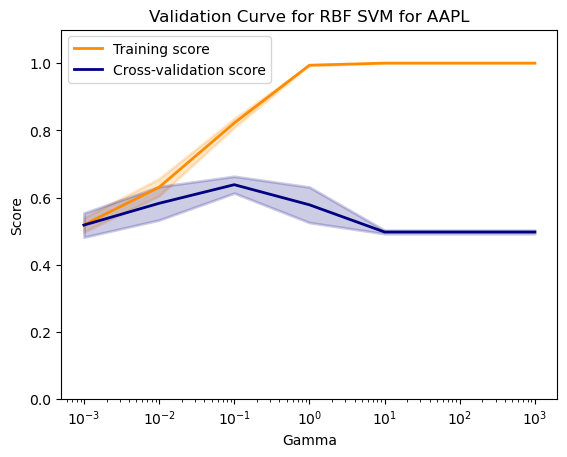

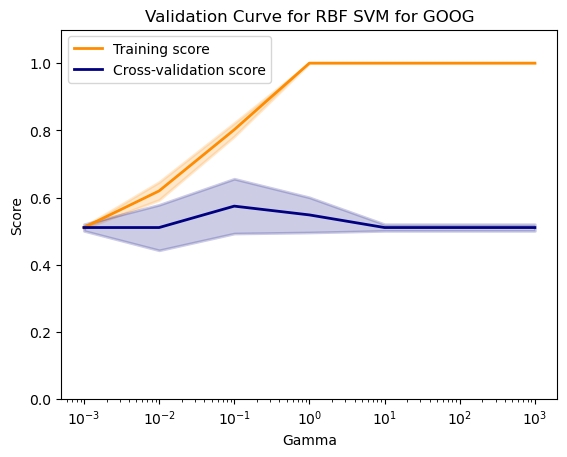

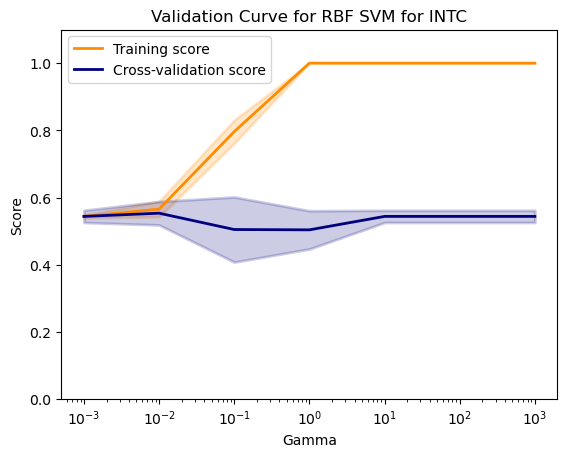

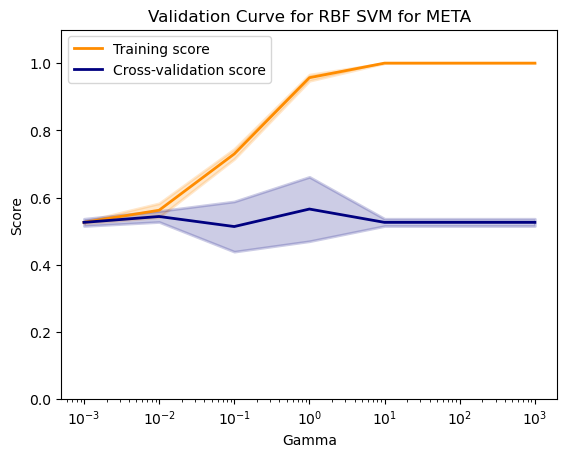

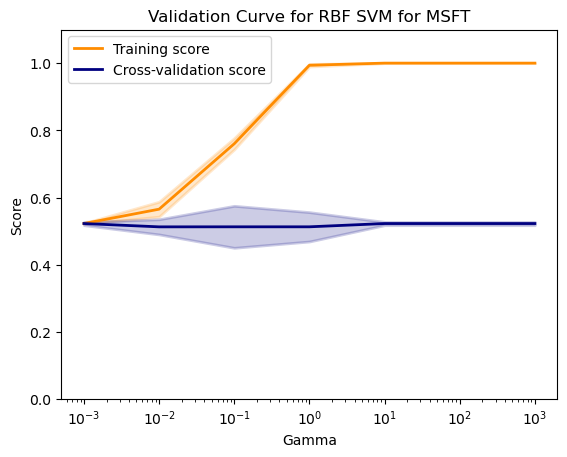

In [23]:
from sklearn.model_selection import train_test_split

stocks = ['AAPL', 'GOOG', 'INTC', 'META', 'MSFT']

for stock in stocks:
    stock_finance_df = pd.read_csv(f'../{stock} Data/{stock}_finance_data.csv')
    stock_sentiment_df = pd.read_csv(f'../{stock} Data/{stock}_avg_sentiment_data.csv')
    merged_stock_df = pd.merge(stock_finance_df, stock_sentiment_df, on='Date', how='inner')
    merged_stock_df = apply_lag_features(merged_stock_df)
    merged_stock_df = drop_na(merged_stock_df)

    features = [
            'Open', 'Close', 'Volume', 'sentiment_compound', 'prev1_open', 'prev1_close','prev1_volume',
            'prev2_volume', 'prev2_open', 'prev2_close', 'prev1_sentiment_compound',
            'prev2_sentiment_compound'
    ]

    X = merged_stock_df[features]
    y = merged_stock_df['target'].astype(float)  # goal is to predict the next day's closing price (classification)

    valid_idx = np.isin(y, [-1, 1]) # removing any row that does not have -1 or 1 as target
    X = X[valid_idx]
    y = y[valid_idx]

    # scale features in order to avoid certain features from dominating others
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    # Define the SVM gamma parameter range
    param_range = np.logspace(-3, 3, 7)

    # Calculate the validation curve for the SVM gamma parameter
    train_scores, test_scores = validation_curve(
        SVC(kernel='rbf'), X_train, y_train, param_name="gamma", param_range=param_range, cv=5)

    # Calculate the mean and standard deviation of the training and testing scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.title(f"Validation Curve for RBF SVM for {stock}")
    plt.xlabel("Gamma")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_mean, label="Training score",
                color="darkorange", lw=lw)
    plt.fill_between(param_range, train_mean - train_std,
                    train_mean + train_std, alpha=0.2,
                    color="darkorange", lw=lw)
    plt.semilogx(param_range, test_mean, label="Cross-validation score",
                color="navy", lw=lw)
    plt.fill_between(param_range, test_mean - test_std,
                    test_mean + test_std, alpha=0.2,
                    color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

# We will use the validation curve results to choose the best gamma value for our SVM model

#### Looking for best C parameter per each stock

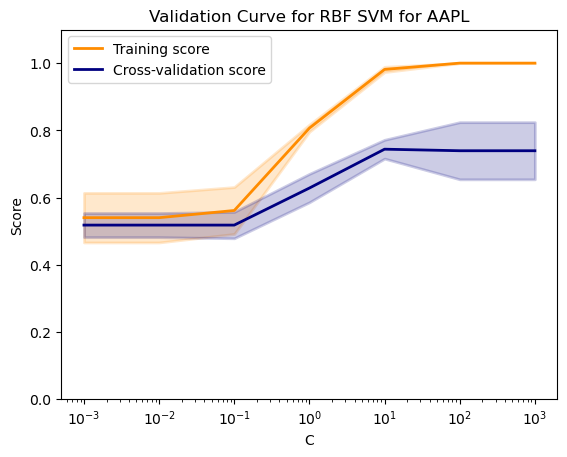

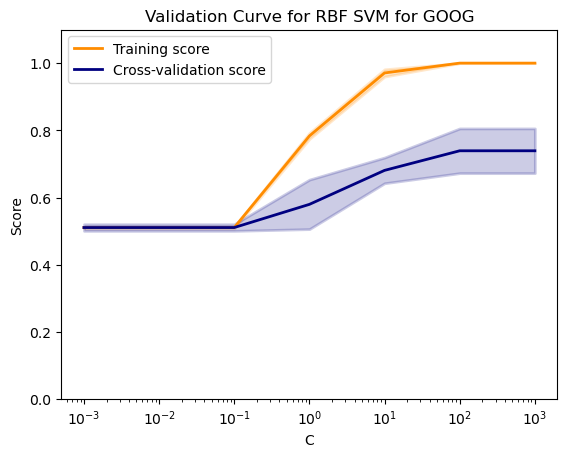

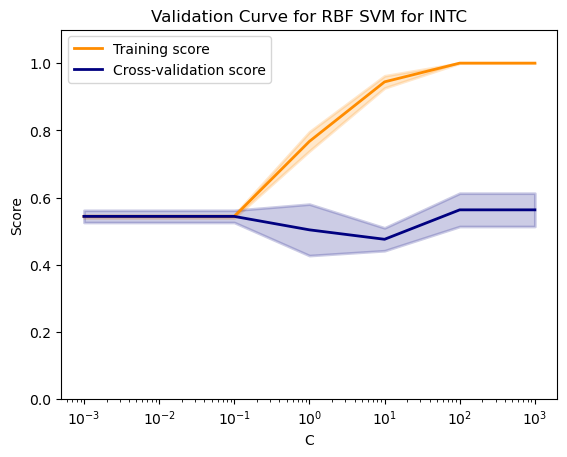

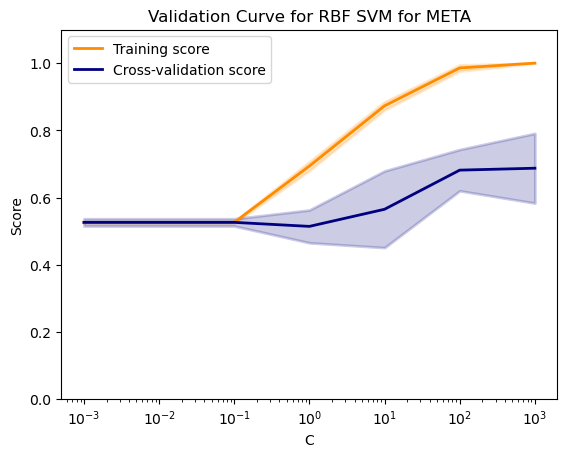

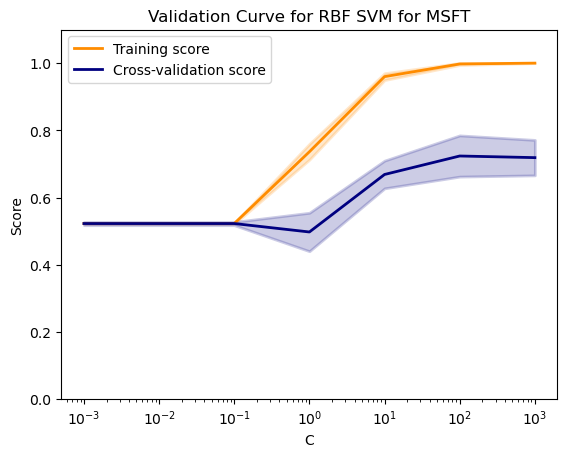

In [24]:
from sklearn.model_selection import train_test_split

stocks = ['AAPL', 'GOOG', 'INTC', 'META', 'MSFT']

for stock in stocks:
    stock_finance_df = pd.read_csv(f'../{stock} Data/{stock}_finance_data.csv')
    stock_sentiment_df = pd.read_csv(f'../{stock} Data/{stock}_avg_sentiment_data.csv')
    merged_stock_df = pd.merge(stock_finance_df, stock_sentiment_df, on='Date', how='inner')
    merged_stock_df = apply_lag_features(merged_stock_df)
    merged_stock_df = drop_na(merged_stock_df)

    features = [
            'Open', 'Close', 'Volume', 'sentiment_compound', 'prev1_open', 'prev1_close','prev1_volume',
            'prev2_volume', 'prev2_open', 'prev2_close', 'prev1_sentiment_compound',
            'prev2_sentiment_compound'
    ]

    X = merged_stock_df[features]
    y = merged_stock_df['target'].astype(float)  # goal is to predict the next day's closing price (classification)

    valid_idx = np.isin(y, [-1, 1]) # removing any row that does not have -1 or 1 as target
    X = X[valid_idx]
    y = y[valid_idx]

    # scale features in order to avoid certain features from dominating others
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    # Define the SVM C parameter range
    param_range = np.logspace(-3, 3, 7)

    # Calculate the validation curve for the SVM gamma parameter
    train_scores, test_scores = validation_curve(
        SVC(kernel='rbf'), X_train, y_train, param_name="C", param_range=param_range, cv=5)

    # Calculate the mean and standard deviation of the training and testing scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.title(f"Validation Curve for RBF SVM for {stock}")
    plt.xlabel("C")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_mean, label="Training score",
                color="darkorange", lw=lw)
    plt.fill_between(param_range, train_mean - train_std,
                    train_mean + train_std, alpha=0.2,
                    color="darkorange", lw=lw)
    plt.semilogx(param_range, test_mean, label="Cross-validation score",
                color="navy", lw=lw)
    plt.fill_between(param_range, test_mean - test_std,
                    test_mean + test_std, alpha=0.2,
                    color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

# We will use the validation curve results to choose the best C value for our SVM model

#### Looking for best parameters for C and Gamma

In [25]:
# combining all stocks data
all_stocks_df = pd.DataFrame()

stocks = ['AAPL', 'GOOG', 'INTC', 'META', 'MSFT']

for stock in stocks:
    stock_finance_df = pd.read_csv(f'../{stock} Data/{stock}_finance_data.csv')
    stock_sentiment_df = pd.read_csv(f'../{stock} Data/{stock}_avg_sentiment_data.csv')
    merged_stock_df = pd.merge(stock_finance_df, stock_sentiment_df, on='Date', how='inner')
    merged_stock_df = apply_lag_features(merged_stock_df)
    merged_stock_df = drop_na(merged_stock_df)
    merged_stock_df['Stock'] = stock
    all_stocks_df = pd.concat([all_stocks_df, merged_stock_df])


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

features = [
    'Open', 'Close', 'Volume', 'sentiment_compound', 'prev1_open', 'prev1_close','prev1_volume',
    'prev2_volume', 'prev2_open', 'prev2_close', 'prev1_sentiment_compound', 'prev2_sentiment_compound'
]

X = all_stocks_df[features]
y = all_stocks_df['target'].astype(float)
valid_idx = np.isin(y, [-1, 1])
X = X[valid_idx]
y = y[valid_idx]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 0.5, 1]
}

svc = SVC(kernel='rbf')
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_scaled, y)

print("Best parameters:", grid_search.best_params_)

best_C = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']

final_svm = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
final_svm.fit(X_scaled, y)  # train on entire combined dataset


Best parameters: {'C': 100, 'gamma': 0.01}


SVC(C=100, gamma=0.01)

## Run SVM (RBF Kernel) Model

In [27]:
def svm_model(df):
    features = [
        'Open', 'Close', 'Volume', 'sentiment_compound', 'prev1_open', 'prev1_close','prev1_volume',
        'prev2_volume', 'prev2_open', 'prev2_close', 'prev1_sentiment_compound',
        'prev2_sentiment_compound'
    ]

    X = df[features]
    y = df['target'].astype(float)  # goal is to predict the next day's closing price (classification)

    valid_idx = np.isin(y, [-1, 1]) # removing any row that does not have -1 or 1 as target
    X = X[valid_idx]
    y = y[valid_idx]

    # scale features in order to avoid certain features from dominating others
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    final_svm = SVC(kernel='rbf', gamma=0.1, C=100)

    # train on the scaled training data
    final_svm.fit(X_train, y_train)

    y_pred = final_svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Test set accuracy:", acc)

    # # confusion matrix
    # cm = confusion_matrix(y_test, y_pred)
    # print("Confusion Matrix:\n", cm)

    # # classification report
    # report = classification_report(y_test, y_pred)
    # print(report)
    

    

In [28]:
# Getting all stocks
stocks = ['AAPL', 'GOOG', 'INTC', 'META', 'MSFT']

for stock in stocks:
    print(stock)
    stock_finance_df = pd.read_csv(f'../{stock} Data/{stock}_finance_data.csv')
    stock_sentiment_df = pd.read_csv(f'../{stock} Data/{stock}_avg_sentiment_data.csv')
    merged_stock_df = pd.merge(stock_finance_df, stock_sentiment_df, on='Date', how='inner')
    merged_stock_df = apply_lag_features(merged_stock_df)
    merged_stock_df = drop_na(merged_stock_df)
    print(f"Num of rows, ", len(merged_stock_df))
    svm_model(merged_stock_df)
    print("\n")


AAPL
Num of rows,  250
Test set accuracy: 0.82


GOOG
Num of rows,  236
Test set accuracy: 0.75


INTC
Num of rows,  131
Test set accuracy: 0.6538461538461539


META
Num of rows,  217
Test set accuracy: 0.6590909090909091


MSFT
Num of rows,  250
Test set accuracy: 0.72


